# Udacity SDC-ND - Project 1

This code implements a solution for Project 1 of the Udacity Self-Driving Car Nanodegree. See README and markdown for a description of this code.

NOTE: The functions below are clearly not fit to be released, as they're completely lacking in
argument management/error checking. This code is intended solely for the purpose of completing
this Udacity project and were left as simple as possible for the sake of time.


# Import Libraries

In [1]:
# Import packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

# Pipeline Helper Functions

In [8]:

def hsv_select(img, color1_lower, color1_upper, color2_lower, color2_upper):
    """ Applies an HSV color transform, and performs color selection of two colors
    Color selection was performed in the HSV color space, since it's much easier to pick
    out individual colors than in RGB space
    """
    #Convert to hsv
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Generate masks
    mask1 = cv2.inRange(hsv, color1_lower, color1_upper)
    mask2 = cv2.inRange(hsv, color2_lower, color2_upper)
    
    # Apply mas to original image
    mask = cv2.bitwise_or(mask1, mask2)
    result = cv2.bitwise_and(img, img, mask = mask)
    
    return result


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    """
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    
def canny(img, low_threshold, high_threshold):
    """Applies a Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, slopes1 = np.array([-0.8, -0.5]), slopes2 = np.array([0.5, 0.8]), color=[255, 0, 0], thickness=15, ):
    """
    Filters a list of passed lines to include only lines of given slopes
    Averages the set of lines of each given slope to determine an average line equation for the set
    Plots the average line on the passed image
    """
    
    # Containers for slopes and y intercepts of lines
    left_slopes = []
    left_b = []
    right_slopes = []
    right_b = []
    
    # Iterate through every line
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            # Calculate slope of line
            slope = np.float64((y2-y1)/(x2-x1))
            
            # Perform slope selection
            if (slope > slopes1[0]) & (slope < slopes1[1]):
                left_slopes.append(slope)
                left_b.append(y1 - slope*x1)
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                continue
                
            if (slope > slopes2[0]) & (slope < slopes2[1]):
                right_slopes.append(slope)
                right_b.append(y1 - slope*x1)
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                continue
    
    # Select y values used to plot average line (ie: how far the lines extend vertically)
    plot_yvals = np.array([img.shape[0]*.65, img.shape[0]])
    
    """ Average out the slopes and y intercepts of the left lines
    to get an average line, and determine (xval, yval) pair.
    """
    numSlopes = len(left_slopes)
    if numSlopes:
        left_slope = sum(left_slopes)/numSlopes
        left_b = sum(left_b)/numSlopes
        
        # Determine x values 
        plot_xvals = (plot_yvals-left_b)/left_slope
        
        plot_xvals = np.int32(np.around(plot_xvals))
        plot_yvals = np.int32(np.around(plot_yvals))
        
        # Plot the line                                     
        cv2.line(img, (plot_xvals[0], plot_yvals[0]), (plot_xvals[1], plot_yvals[1]), color, thickness)
        
    
    # Do the same for right lane markers
    numSlopes = len(right_slopes)
    if numSlopes:
        right_slope = sum(right_slopes)/numSlopes
        right_b = sum(right_b)/numSlopes
 
        plot_xvals = (plot_yvals-right_b)/right_slope
        
        plot_xvals = np.int32(np.around(plot_xvals))
        plot_yvals = np.int32(np.around(plot_yvals))
  
        cv2.line(img, (plot_xvals[0], plot_yvals[0]), (plot_xvals[1], plot_yvals[1]), color, thickness)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, slopes1 = np.array([-0.8, -0.5]), slopes2 = np.array([0.5, 0.8])):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)





# Pipeline Function

In [9]:
def process_image(image):
    """
    Processes an image to return lines that indicate lane markings.
    This function contains a lot of "magic numbers" that, as mentioned in the 
    note at the beginning of this notebook section, wouldn't fly in a 
    released verion.
    """
    # Define yellow and white colors for used in color selection
    lower_yellow = np.array([20, 80, 200])
    upper_yellow = np.array([70, 255, 255])
    lower_white = np.array([0, 0, 220])
    upper_white = np.array([255, 255, 255])
    
    # Perform color selection
    color_slct = hsv_select(image, lower_yellow, upper_yellow, lower_white, upper_white)
    
    # Convert to grayscale, which is required for Canny edge detection
    gray = grayscale(color_slct)
    
    # Apply gaussian blurring
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # Canny edge detection
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Some math to create a polygon for region of interest selection 
    # that can be used for images of various sizes
    imshape = edges.shape
    poly_x = .1*imshape[1] # width of the upper portion of the polygon
    poly_y = round(.6*imshape[0]) # y location of upper portion of polygon
    top_left = (np.int32(round(imshape[1]/2-poly_x/2)), np.int32(poly_y)) # top left of polygon
    top_right = (np.int32(round(imshape[1]/2+poly_x/2)), np.int32(poly_y)) # top right of polygon

    vertices = np.array([[(0, imshape[0]), top_left, top_right, (imshape[1], imshape[0])]], dtype=np.int32)
    
    # Apply region of interest             
    edges_poly = region_of_interest(edges, vertices)

    
    # Apply Hough tansform
    rho = 1
    theta = np.pi/180
    threshold = 8
    min_line_length = 17
    max_line_gap = 10

    line_image = hough_lines(edges_poly, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Overlay images
    result = weighted_img(line_image, image)
    
    return result

# Test Pipeline on Images

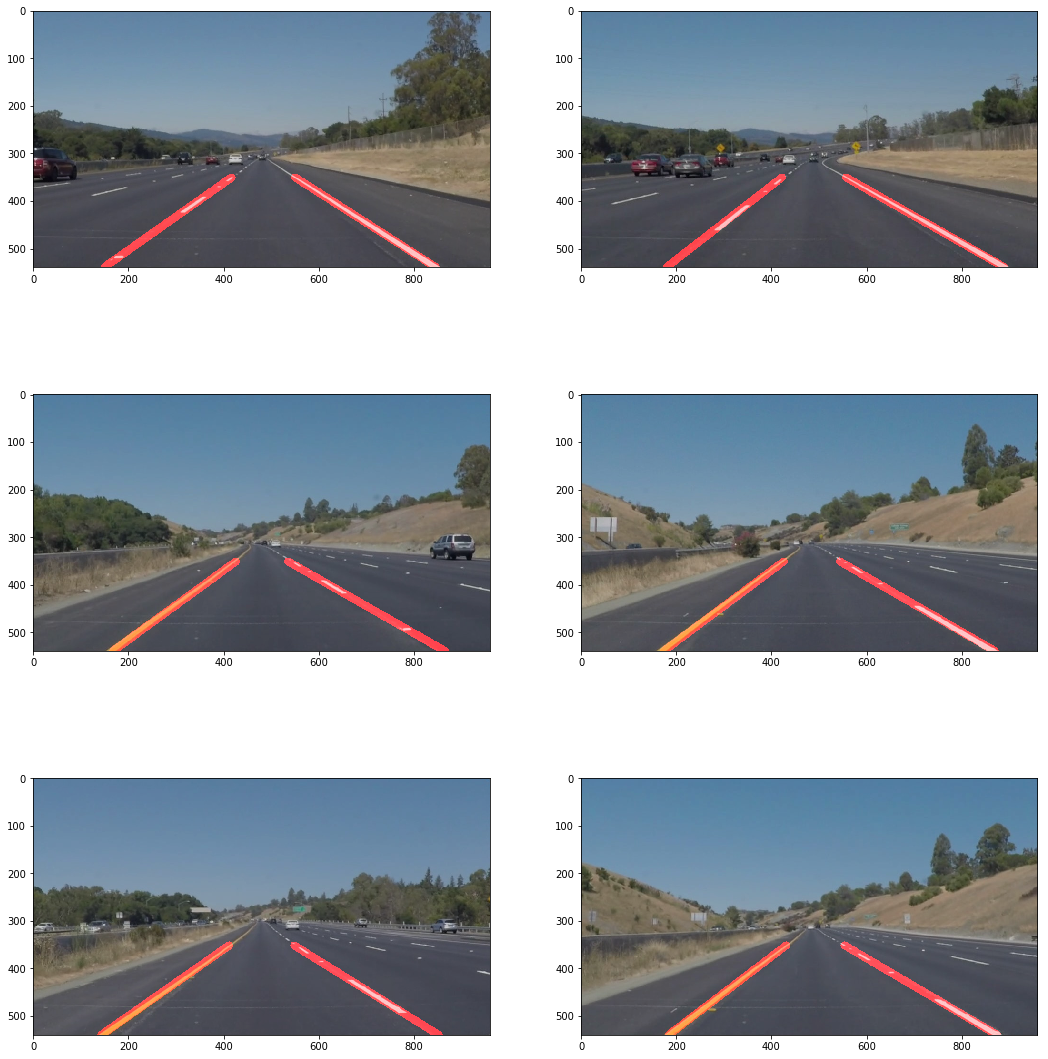

In [10]:
# Image strings: 
image_name = []
image_name.append("test_images/solidWhiteRight.jpg")
image_name.append("test_images/solidWhiteCurve.jpg")
image_name.append("test_images/solidYellowCurve.jpg")
image_name.append("test_images/solidYellowCurve2.jpg")
image_name.append("test_images/solidYellowLeft.jpg")
image_name.append("test_images/whiteCarLaneSwitch.jpg")

columns = 2
numPlots = len(image_name)
rows = int(math.ceil(numPlots/2))

plotNum = 1
plt.figure(figsize = (18, 20))

for name in image_name:
    image = mpimg.imread(name)
    lines_edges = process_image(image)
    plt.subplot(rows, columns, plotNum)
    plt.imshow(lines_edges)
    plotNum = plotNum + 1


# Test Pipeline on Videos

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
white_output = 'test_videos_output/solidWhiteRight.mp4'

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [00:03<00:00, 58.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 4.22 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [14]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'

clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████▉| 681/682 [00:11<00:00, 57.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 12.2 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [16]:
challenge_output = 'test_videos_output/challenge.mp4'

clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████| 251/251 [00:08<00:00, 27.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 9.89 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))